# Notebook 5: Use GraphStorm APIs for a Customized Model to Perform Graph Prediction

Graph prediction, such as graph classification or graph regression, is a common task in Graph Machine Learning (GML) across various domains, including life sciences and chemistry. In graph prediction, the entire graph data is typically organized as a batch of subgraphs, where each subgraph's nodes have edges only within the subgraph and no edges connecting to nodes in other subgraphs. GML labels are linked to these subgraphs. Once trained, GML models can make predictions on new and unseen subgraphs.

A typical operation used in graph prediction is called `Read-out`, which aggregates the representations of nodes in a subgraph to form one representation for the subgraph. The outputs of the `Read-out` can then be used to make predictions downstream, acting as a single representation of the entire subgraph.

<img src="../../../../tutorial/GP_readout.png" style="margin:auto" width="400"/>

The current version of GraphStorm can not directly perform graph prediction. But as GraphStorm supports node-level prediction, we can use a method called `supernode` to perform graph-level predictions.

----

## `super-node` Method Explanation

Instead of using the `Read-out` operation, we add a new node, called **super node**, to each subgraph, and link all original nodes of the subgraph to it, but not adding reversed edges. With these inbound edges, representations of all original nodes in a subgraph could be easily aggregated to the **super node**. We can then use the **super node** as the representation of this subgraph to perform graph-level prediction tasks. The `super-node` method helps us to turn a graph prediction task into a node prediction task.

<img src="../../../../tutorial/GP_supernode.png" style="margin:auto" width="300"/>

----

## Implementation Ideas

In order to use the `super-node` method in GraphStorm, we need to implement two extra functions.

- **Raw Graph Data Conversion**: 
    Add a super node to each subgraph in the original batch of subgraphs, and store all of them as one heterogenous graph ready for GraphStorm's graph construction CLIs. After be constructed into GraphStorm's distributed graph format, we can use all GraphStorm's built-in GNN model to perform the `super-node` prediction.
- **Customized GNN Encoder** (Optional):
    Create a customized GNN encoder for specific aggregation method for **super nodes**. This is an optional function as all built-in GraphStorm GNN encoders can aggregate and generate embeddings for **super nodes** naturally. But creating a customized GNN encoder could have fine-granular control of aggregation methods, which might minic the `Read-out` method.

This notebook will demonstrate the `super-node` method by using GraphStorm APIs and other libraries to implement both functions. This notebook serves as an example of a Graph Classification Solution using GrahpStorm APIs. Users can modify the customer GNN model and implement their own version.

-----

## Prerequisites
This notebook assumes the following:
- Python 3;
- Linux OS, Ubuntu or Amazon Linux;
- GraphStorm and its dependencies (following the [Setup GraphStorm with pip packages tutorial](https://graphstorm.readthedocs.io/en/latest/install/env-setup.html#setup-graphstorm-with-pip-packages))
- [Jupyter web interactive server](https://jupyter.org/).

---

## 1. Raw Graph Data Conversion

Converting the raw graph prediction dataset into `super-node` format for GraphStorm could be illustrated as the diagram below.

<img src="../../../../tutorial/GP_data_conversion.png" style="margin:auto" width="750"/>

In this notebook, we use the [OGBG Molhiv Data](https://ogb.stanford.edu/docs/graphprop/#ogbg-mol), which is a popular graph property prediction dataset. 
Due to the large number of lines of code, we will not show the actual raw graph data conversion code in this notebook. Users can find the [souce code of OGBG data conversion](https://github.com/awslabs/graphstorm/blob/main/examples/graph_prediction/gen_ogbg_supernode.py) in GraphStorm's [graph prediction example folder](https://github.com/awslabs/graphstorm/blob/main/examples/graph_prediction/).

<div class="alert alert-block alert-info">
<b>Tip:</b> We also provide a Python script to generate synthetic supernode-based graph data for user to better understand the `super-node` grahp data format, which is avaible <a href="https://github.com/awslabs/graphstorm/blob/main/docs/source/api/notebooks/dummy_gc_data.py"><u>here</u></a>.</div>


We can download the source code of the OGBG conversion and generate the `super-node` format OGBG data with the following commands.


In [1]:
!wget -c https://raw.githubusercontent.com/awslabs/graphstorm/main/examples/graph_prediction/gen_ogbg_supernode.py

!python gen_ogbg_supernode.py --ogbg-data-name molhiv --output-path ./supernode_raw/

The converted OGBG data will be stored at `./supernode_raw/`. Then we can run GraphStorm's gconstruct command to partition the graph for model training and inference. The processed graph is stored in the `/supernode_gs_1p/` folder.

In [4]:
!python -m graphstorm.gconstruct.construct_graph \
        --conf-file ./supernode_raw/config.json \
        --output-dir ./supernode_gs_1p/ \
        --num-parts 1 \
        --graph-name supernode_molhiv

<div class="alert alert-block alert-warning">
<b>Tip:</b> If the above Python commands fail to run in a Notebook, please run it in a Linux terminal environment where GraphStorm is install.</div>

## 2. Customized GNN Encoder for Graph Prediction

The key component of this `super-node` based solution is the GNN model that can perform message passing and aggregation in each subgraph, and then perform sorts of `Read-out` operation in the super nodes. This component could be easily implemented as a customized GraphStorm GNN Encoder like demonstrated in the [Notebook 4: Customized Models](https://graphstorm.readthedocs.io/en/latest/api/notebooks/Notebook_4_Customized_Models.html)

As shown in the diagram below, a **super node** will aggregate the representations from other nodes in each GNN layer. Built-in GNN encoders will udpate the aggregated representations with an additional trainable parameters. This operation is different from the common `Read-out` operation, hence causing worse performance.

<img src="../../../../tutorial/GP_layer_agg.png" style="margin:auto" width="350"/>

To mimic the `Read-out` operation, we can cache the aggregated representations, and clean the **super node**'s own representation to zeros after each GNN layer computation. Using this method, we can still leverage the built-in GraphStorm encoders, e.g., `RelationalGCNEncoder` and `RelationalGATEncoder`, but avoid the built-in self-update operation from one layer to another. In addition, we can design more flexible `Read-out` function on these cached representations, other than just use the last layer's aggregation presentations.

The below `GPEncoder4SupernodeOgbg` class implements this cache representations mechanism, and provides a few options for the read-out function.

In [2]:
import torch as th
from graphstorm.model import (GSgnnNodeModel,
                              GSNodeEncoderInputLayer,
                              RelationalGCNEncoder,
                              RelationalGATEncoder,
                              HGTEncoder,
                              EntityClassifier,
                              ClassifyLossFunc)
from graphstorm.model.gnn_encoder_base import GraphConvEncoder

class GPEncoder4SupernodeOgbg(GraphConvEncoder):
    r"""A graph conv encoder for Graph Classification

        Unique arguments in this class:
        -------------------------------
        base_encoder: GraphStorm ConvEncoder types, options:
            1. `RelationalGCNEncoder`;
            2. `RelationalGATEncoder`;
            3. `HGTEncoder`.
        read_out_opt: string in the following options:
            The aggregation method for the cached supernodes' representations. The current options:
            1. `last_only`: only use the last layer's representations. If use this option, 
               the read_out_ops will be ignored because there is only one layer representation
               is involved in the final read_out.
            2. `mean`: compute the mean of all of the cached supernode representations.
            3. `sum`: compute the summantion of all of the cached supernode representations.
            4. `weighted_sum`: use additional weight parameters to compute the weighted summation
               all of the cached supernode representations.
            5. `min`: compute the minimum in each dimension of the all of the cached supernode
               representations.
            6. `max`: compute the maximum in each dimension of the all of the cached supernode
               representations.
        super_ntype: string
            The name of supernode type. Default is 'super'.

    """
    def __init__(self,
                 h_dim,
                 out_dim,
                 base_encoder,
                 read_out_opt='last_only',
                 super_ntype='super'
                ):
        assert isinstance(base_encoder, (RelationalGCNEncoder, RelationalGATEncoder, HGTEncoder)), \
               'Only support GraphStorm\'s RelationalGCNEncoder, RelationalGATEncoder, and HGTEncoder'
        assert base_encoder.num_layers >= 3, 'For Graph Prediction task, at least two layers GNN' + \
                                       f'encoder required, but got {num_hidden_layers} ...'
        super(GPEncoder4SupernodeOgbg, self).__init__(h_dim, out_dim, base_encoder.num_layers)

        assert read_out_opt in ['last_only', 'mean', 'sum', 'weighted_sum', 'min', 'max'], + \
                                f'Not recognized read_out_opt {read_out_opt}. Options include ' + \
                                '\'last_only\', \'mean\', \'sum\', \'weighted_sum\', \'mim\', ' + \
                                'and \'max\'.'
        self.base_encoder = base_encoder
        self.read_out_opt = read_out_opt
        self.super_ntype = super_ntype
        if read_out_opt=='weighted_sum':
            self.weighted_sum_para = th.nn.Parameter(th.Tensor(1, num_hidden_layers))

    def forward(self, blocks, h):

        supernode_cache = []

        # message passing in subgraphs and cache super-nodes representations
        for layer, block in zip(self.base_encoder.layers, blocks):
            h = layer(block, h)

            # 1. cache the output of supernodes in each layer
            supernode_cache.append(h[self.super_ntype])
            # 2. zero out the representations of supernodes as the next layer input
            h[self.super_ntype] = th.zeros_like(h[self.super_ntype])

        # add final read_out functions.
        supernode_cache = th.stack(supernode_cache)
        output = self._read_out_ops(supernode_cache)

        return {self.super_ntype: output}

    def _read_out_ops(self, supernode_cache):
        """ The supernode_cache shape L * N * D
            The output shape N * D
        """
        if self.read_out_opt=='last_only':
            output = supernode_cache[-1]
        elif self.read_out_opt=='mean':
            output = th.mean(supernode_cache, dim=0)
        elif self.read_out_opt=='sum':
            output = th.sum(supernode_cache, dim=0)
        elif self.read_out_opt=='weighted_sum':
            output = th.einsum('ij, jkl->kl', self.weighted_sum_para, supernode_cache)

        return output

/home/ec2-user/anaconda3/envs/gsf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ec2-user/anaconda3/envs/gsf/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/ec2-user/anaconda3/envs/gsf/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## 3. Training and Inference Pipeline

With the customized encoder modified for graph prediction, we can reuse GraphStorm's end-to-end training and inference pipeline as the one in the [Notebook 1: Node Classification Pipeline](https://graphstorm.readthedocs.io/en/latest/api/notebooks/Notebook_1_NC_Pipeline.html) and 
[Notebook 2: Link Prediction Pipeline](https://graphstorm.readthedocs.io/en/latest/api/notebooks/Notebook_2_LP_Pipeline.html) to conduct the graph classification task on the converted `super-node` OGBG data.

In [3]:
import logging
logging.basicConfig(level=20)

import graphstorm as gs
gs.initialize()

In [6]:
ogbg_data = gs.dataloading.GSgnnData(part_config='./supernode_gs_1p/supernode_molhiv.json')

INFO:root:Start to load partition from ./supernode_gs_1p/part0/graph.dgl which is 110126629 bytes. It may take non-trivial time for large partition.
INFO:root:Finished loading partition.
INFO:root:Finished loading node data.
INFO:root:Finished loading edge data.


In [7]:
# define dataloaders for training, validation, and testing
nfeats_4_modeling = {'node': ['n_feat'], 'super': ['n_feat']}

train_dataloader = gs.dataloading.GSgnnNodeDataLoader(
    dataset=ogbg_data,
    target_idx=ogbg_data.get_node_train_set(ntypes=['super']),
    node_feats=nfeats_4_modeling,
    label_field='labels',
    fanout=[20, 20, 20],
    batch_size=128,
    train_task=True)
val_dataloader = gs.dataloading.GSgnnNodeDataLoader(
    dataset=ogbg_data,
    target_idx=ogbg_data.get_node_val_set(ntypes=['super']),
    node_feats=nfeats_4_modeling,
    label_field='labels',
    fanout=[100, 100, 100],
    batch_size=256,
    train_task=False)
test_dataloader = gs.dataloading.GSgnnNodeDataLoader(
    dataset=ogbg_data,
    target_idx=ogbg_data.get_node_test_set(ntypes=['super']),
    node_feats=nfeats_4_modeling,
    label_field='labels',
    fanout=[100, 100, 100],
    batch_size=256,
    train_task=False)

INFO:root:part 0, train 32901
INFO:root:part 0, val 4113
INFO:root:part 0, test 4113


In terms of GNN model, we can create a GraphStorm GNN model using nearly the same architecture as in the other notebooks, except that we replace the built-in GNN encoders, e.g., `RelationGCNEncoder` with the customized `GPEncoder4SupernodeOgbg`, which wraps a `RelationGCNEncoder` as its base encoder.

In [10]:
class RgcnGCModel4SuperOgbg(GSgnnNodeModel):
    """ A customized GNN model for graph classification using Graphstorm APIs

    Arguments
    ----------
    g: DistGraph
        A DGL DistGraph.
    num_hid_layers: int
        The number of gnn layers.
    node_feat_field: dict of list of strings
        The list features for each node type to be used in the model.
    hid_size: int
        The dimension of hidden layers.
    num_classes: int
        The target number of classes for classification.
    multilabel: boolean
        Indicator of if this is a multilabel task.
    """
    def __init__(self,
                 g,
                 num_hid_layers,
                 node_feat_field,
                 hid_size,
                 num_classes,
                 multilabel=False):
        super(RgcnGCModel4SuperOgbg, self).__init__(alpha_l2norm=0.)

        # extract feature size
        feat_size = gs.get_node_feat_size(g, node_feat_field)

        # set an input layer encoder
        encoder = GSNodeEncoderInputLayer(g=g, feat_size=feat_size, embed_size=hid_size)
        self.set_node_input_encoder(encoder)

        # set an RGCN  encoder as the base encoder
        gnn_encoder = RelationalGCNEncoder(g=g,
                                           h_dim=hid_size,
                                           out_dim=hid_size,
                                           num_hidden_layers=num_hid_layers)
        # wrap the base RGCN encoder into GPEncoder4SupernodeOgbg
        gp_encoder = GPEncoder4SupernodeOgbg(hid_size,
                                             hid_size,
                                             gnn_encoder,
                                             read_out_opt='last_only',
                                             super_ntype='super')
        self.set_gnn_encoder(gp_encoder)

        # set a decoder specific to node classification task
        decoder = EntityClassifier(in_dim=hid_size,
                                   num_classes=num_classes,
                                   multilabel=multilabel)
        self.set_decoder(decoder)

        # classification loss function
        self.set_loss_func(ClassifyLossFunc(multilabel=multilabel))

        # initialize model's optimizer
        self.init_optimizer(lr=0.001,
                            sparse_optimizer_lr=0.001,
                            weight_decay=0)


In [11]:
model = RgcnNCModel4SuperOgbg(g=ogbg_data.g,
                              num_hid_layers=3,
                              node_feat_field=nfeats_4_modeling,
                              hid_size=128,
                              num_classes=2)

In [12]:
# setup a classification evaluator for the trainer
evaluator = gs.eval.GSgnnClassificationEvaluator(eval_frequency=100,
                                                 eval_metric_list=['roc_auc'])

In [13]:
# create a GraphStorm node task trainer for the RGCN model
trainer = gs.trainer.GSgnnNodePredictionTrainer(model)
trainer.setup_evaluator(evaluator)
trainer.setup_device(gs.utils.get_device())

In [14]:
# Train the model with the trainer using fit() function
trainer.fit(train_loader=train_dataloader,
            val_loader=val_dataloader,
            test_loader=test_dataloader,
            num_epochs=50,
            save_model_path='a_save_path/')

INFO:root:Part 0 | Epoch 00000 | Batch 000 | Loss: 0.4890 | Time: 0.1570
INFO:root:Part 0 | Epoch 00000 | Batch 020 | Loss: 0.1473 | Time: 0.0413
INFO:root:Part 0 | Epoch 00000 | Batch 040 | Loss: 0.2024 | Time: 0.0310
INFO:root:Part 0 | Epoch 00000 | Batch 060 | Loss: 0.1660 | Time: 0.0342
INFO:root:Part 0 | Epoch 00000 | Batch 080 | Loss: 0.1361 | Time: 0.0334
INFO:root:Step 100 | Train loss: 0.2344
INFO:root:Step 100 | Validation roc_auc: 0.5889
INFO:root:Step 100 | Test roc_auc: 0.6477
INFO:root:Step 100 | Best Validation roc_auc: 0.5889
INFO:root:Step 100 | Best Test roc_auc: 0.6477
INFO:root:Step 100 | Best Iteration roc_auc: 100.0000
INFO:root: Eval time: 1.9635, Evaluation step: 100.
INFO:root:Part 0 | Epoch 00000 | Batch 100 | Loss: 0.2008 | Time: 0.0345
INFO:root:Part 0 | Epoch 00000 | Batch 120 | Loss: 0.0778 | Time: 0.0435
INFO:root:Part 0 | Epoch 00000 | Batch 140 | Loss: 0.2142 | Time: 0.0327
INFO:root:Part 0 | Epoch 00000 | Batch 160 | Loss: 0.2008 | Time: 0.0311
INFO:ro

Next, we examine the model performance over the training process

In [15]:
# Extract accuracies from the trainer's evaluator:
val_accs, test_accs = [], []
for val_acc, test_acc in trainer.evaluator.history:
    val_accs.append(val_acc['roc_auc'])
    test_accs.append(test_acc['roc_auc'])

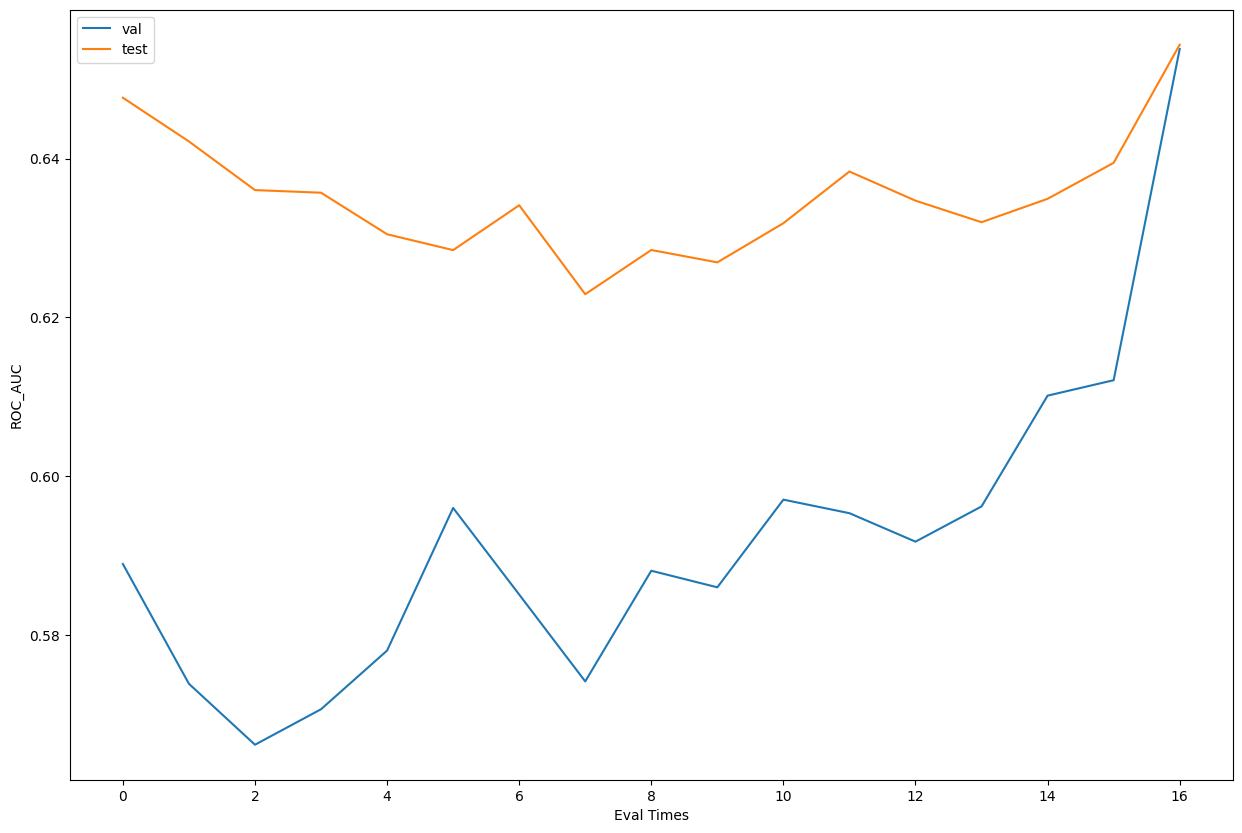

In [16]:
import matplotlib.pyplot as plt

# plot the learning curves
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(val_accs, label='val')
ax.plot(test_accs, label='test')
ax.set(xlabel='Eval Times', ylabel='ROC_AUC')
ax.legend(loc='best');

In [17]:
# after training, the best model is saved to disk:
best_model_path = trainer.get_best_model_path()
print('Best model checkpoint:', best_model_path)

Best model checkpoint: a_save_path/epoch-4


In [18]:
# check the saved artifacts
!ls -ls {best_model_path}

total 2372
 792 -rw-rw-r-- 1 ec2-user ec2-user  808835 Sep 13 00:42 model.bin
1580 -rw-rw-r-- 1 ec2-user ec2-user 1617186 Sep 13 00:42 optimizers.bin


### 3. Inference with the trained model

In [19]:
# we can restore the model from the checkpoint:
model.restore_model(best_model_path)

INFO:root:successfully load the model from a_save_path/epoch-4
INFO:root:Time on load model: 0.006 seconds


In [20]:
# Setup dataloader for inference
infer_dataloader = gs.dataloading.GSgnnNodeDataLoader(dataset=ogbg_data,
                                                      target_idx=ogbg_data.get_node_test_set(ntypes=['super']),
                                                      node_feats=nfeats_4_modeling,
                                                      label_field='labels',
                                                      fanout=[100, 100, 100],
                                                      batch_size=256,
                                                      train_task=False)

INFO:root:part 0, test 4113


In [21]:
# Create an Inferrer object
infer = gs.inference.GSgnnNodePredictionInferrer(model)

# Run inference on the inference dataset
infer.infer(infer_dataloader,
            save_embed_path='infer/embeddings',
            save_prediction_path='infer/predictions',
            use_mini_batch_infer=True)

INFO:root:save embeddings pf super to infer/embeddings
INFO:root:Writing GNN embeddings to infer/embeddings in pytorch format.


In [30]:
# The GNN embeddings on the inference graph are saved to:
!ls -lh infer/embeddings
!ls -lh infer/embeddings/super/

total 8.0K
-rw-rw-r-- 1 ec2-user ec2-user   89 Sep 13 00:44 emb_info.json
drwxrwxr-x 2 ec2-user ec2-user 4.0K Sep 13 00:44 super
total 2.1M
-rw-rw-r-- 1 ec2-user ec2-user 2.1M Sep 13 00:44 embed-00000.pt
-rw-rw-r-- 1 ec2-user ec2-user  34K Sep 13 00:44 embed_nids-00000.pt


In [29]:
!ls -lh infer/predictions
!ls -lh infer/predictions/super

total 8.0K
-rw-rw-r-- 1 ec2-user ec2-user   87 Sep 13 00:44 result_info.json
drwxrw-rwx 2 ec2-user ec2-user 4.0K Sep 13 00:44 super
total 72K
-rw-rw-r-- 1 ec2-user ec2-user 34K Sep 13 00:44 predict-00000.pt
-rw-rw-r-- 1 ec2-user ec2-user 34K Sep 13 00:44 predict_nids-00000.pt
